# CPSC 8810 Final Project: Deep Learning for Computational Photography

Before we start, please put your name and CUID in following format

Name: ABDUL HANNAN, CUID: C11817150

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
#Skipping this step as i didnt use google colab.

# Data preprocessing

## Setup code
Import some useful packages and increase the default figure size.

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [4]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Good to go!


# Load the dataset

Note: You need to create a dataloader to load the training and testing images. You may need to modify the data loader based on your own project's data types.

Please save your training data in a folder named "train", and testing/validation data in folder "val"

In [5]:
# Custom NYU Depth Dataset
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit=None, is_train=True):
        self.transform = transform
        self.rgb_paths, self.depth_paths = [], []

        if is_train:
            # traversing subfolders under root_dir
            subfolders = [os.path.join(root_dir, d)
                          for d in os.listdir(root_dir)
                          if os.path.isdir(os.path.join(root_dir, d))]
            for fold in subfolders:
                for fn in os.listdir(fold):
                    if not fn.endswith('.jpg'):
                        continue
                    rgb = os.path.join(fold, fn)
                    dp  = rgb.replace('.jpg', '.png')
                    if os.path.exists(dp):
                        self.rgb_paths.append(rgb)
                        self.depth_paths.append(dp)
                    if limit and len(self.rgb_paths) >= limit:
                        break
                if limit and len(self.rgb_paths) >= limit:
                    break
        else:
            # flat val/test folder
            for fn in os.listdir(root_dir):
                if not fn.endswith('_colors.png'):
                    continue
                rgb = os.path.join(root_dir, fn)
                dp  = rgb.replace('_colors.png', '_depth.png')
                if os.path.exists(dp):
                    self.rgb_paths.append(rgb)
                    self.depth_paths.append(dp)
                if limit and len(self.rgb_paths) >= limit:
                    break

        mode = "Train" if is_train else "Test"
        print(f"{mode} RGB Images:   {len(self.rgb_paths)}")
        print(f"{mode} Depth Images: {len(self.depth_paths)}")

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        # load RGB image
        rgb = Image.open(self.rgb_paths[idx]).convert("RGB")
        if self.transform:
            rgb = self.transform(rgb)

        # load depth as 16-bit PNG - float meters
        depth_png = np.array(Image.open(self.depth_paths[idx]), dtype=np.uint16)
        depth_m   = depth_png.astype(np.float32) / 1000.0  # mm → m
        depth     = torch.from_numpy(depth_m).unsqueeze(0)  # [1, H, W]

        return rgb, depth

In [6]:
# loading the dataset
train_dir = '/home/abdul/Deep_Learning/Project/nyu_data/data/nyu2_train'
test_dir  = '/home/abdul/Deep_Learning/Project/nyu_data/data/nyu2_test'

# Data transforms (only for RGB)
rgb_transform = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor(),
])

full_train = NYUDepthDataset(
    root_dir  = train_dir,
    transform = rgb_transform,
    limit     = 40000,
    is_train  = True
)

# split into train / val
n_train = int(0.8 * len(full_train))
n_val   = len(full_train) - n_train
train_ds, val_ds = random_split(full_train, [n_train, n_val])

# test dataset
test_ds = NYUDepthDataset(
    root_dir  = test_dir,
    transform = rgb_transform,
    limit     = 2000,
    is_train  = False
)

Train RGB Images:   40000
Train Depth Images: 40000
Test RGB Images:   654
Test Depth Images: 654


## Load the data
Note: This section loads the dataset from the specified directory. Replace 'path/to/dataset' with the actual path to your dataset. The ImageFolder class from torchvision is used to load the images and their corresponding labels.


This section creates data loaders for training and validation sets. The batch_size parameter determines the number of samples in each batch. The shuffle=True parameter ensures that the data is shuffled during training.


In [7]:
# DataLoaders
loader_kwargs = dict(batch_size=4, num_workers=8, pin_memory=(device.type=='cuda'))
train_loader = DataLoader(train_ds,  shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,    shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_ds,   shuffle=False, **loader_kwargs)

## Visualize the loaded training and testing image pairs
Note: Print out a row a traing/validation data. Print out the input and output of the network:
- For Depth from 2D, please print out the input image and its corresponding depth map
- For PointCloud from 2D, please print out the input image and its corresponding point cloud. You may need to install PyTorch 3D for visualizing the point clould
- For NeRF, please print out the first batch input image of both Training and Testing

Training Data:


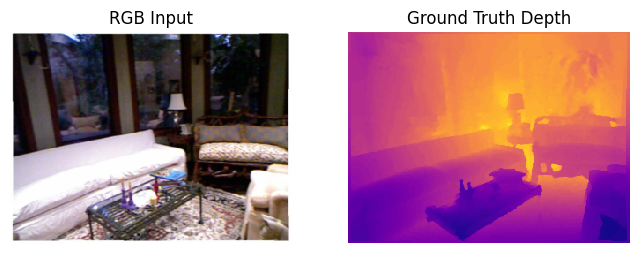

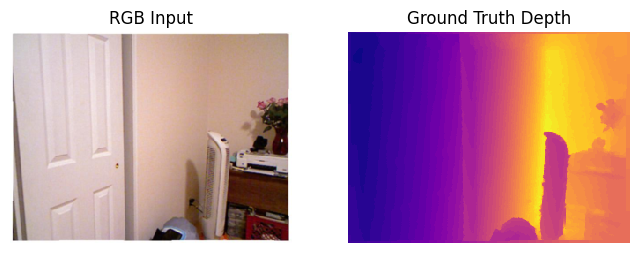

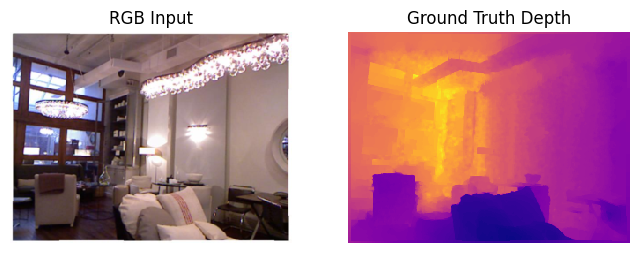


Validation Data:


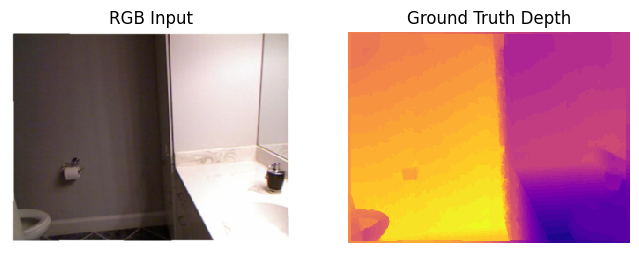

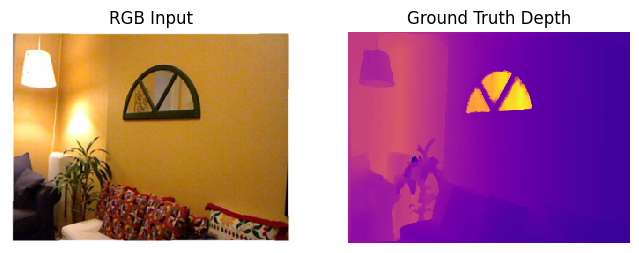

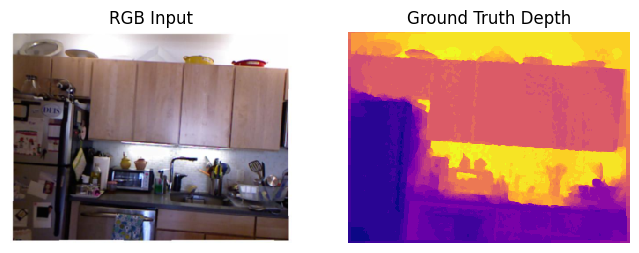

In [9]:
# Define your visualization algorithm.
import matplotlib.pyplot as plt

def visualize_data(data_loader, num_images=1):
    ############## Insert your code below ###############
    # Since the model isn’t defined yet in this cell, we only visualize
    # the raw input RGB and the ground-truth depth maps.
    for imgs, depths in data_loader:
        # display up to num_images examples from the first batch
        for i in range(min(num_images, imgs.size(0))):
            rgb = imgs[i].cpu()
            gt  = depths[i].cpu().squeeze(0).numpy()
            # normalize for display
            gt_n = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)

            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(transforms.ToPILImage()(rgb))
            axes[0].set_title('RGB Input')
            axes[0].axis('off')

            axes[1].imshow(gt_n, cmap='plasma')
            axes[1].set_title('Ground Truth Depth')
            axes[1].axis('off')

            plt.show()
        break  # only the first batch
    ####################################################

# collecting dataloaders into a dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

# Printing out a row of training/validation data
print("Training Data:")
visualize_data(dataloaders['train'], num_images=3)

print("\nValidation Data:")
visualize_data(dataloaders['val'],   num_images=3)

# Define the Deep Learning model
Note: In this section, you need to define your own Deep Learning models for prediction

In [10]:
# Define the CNN model

class DenseEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # use DenseNet-121’s feature layers (no pretrained weights)
        dnet = torchvision.models.densenet121(weights=None).features
        # initial conv + pool
        self.init = nn.Sequential(
            dnet.conv0, dnet.norm0, dnet.relu0, dnet.pool0
        )
        # four dense-blocks + three transition layers
        self.block1, self.trans1 = dnet.denseblock1, dnet.transition1
        self.block2, self.trans2 = dnet.denseblock2, dnet.transition2
        self.block3, self.trans3 = dnet.denseblock3, dnet.transition3
        self.block4             = dnet.denseblock4  # final bottleneck

    def forward(self, x):
        x0 = self.init(x)       # [B,64,   H/2,  W/2]
        x1 = self.block1(x0)    # [B,256,  H/2,  W/2]
        p1 = self.trans1(x1)    # [B,128,  H/4,  W/4]
        x2 = self.block2(p1)    # [B,512,  H/4,  W/4]
        p2 = self.trans2(x2)    # [B,256,  H/8,  W/8]
        x3 = self.block3(p2)    # [B,1024, H/8,  W/8]
        p3 = self.trans3(x3)    # [B,512,  H/16, W/16]
        x4 = self.block4(p3)    # [B,1024, H/16, W/16]
        return x1, x2, x3, x4


class DenseUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = DenseEncoder()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        # decoder: upsample + concat(skip) + conv_block
        self.up4  = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(512+1024, 512)

        self.up3  = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(256+512, 256)

        self.up2  = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(128+256, 128)

        self.up1  = nn.ConvTranspose2d(128,  64, kernel_size=2, stride=2)
        self.dec1 = conv_block(64+256, 64)  # re-use x1’s channels here

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4 = self.encoder(x)

        # Stage 4
        u4 = self.up4(x4)
        if u4.shape[2:] != x3.shape[2:]:
            u4 = F.interpolate(u4, size=x3.shape[2:], mode='bilinear', align_corners=False)
        d4 = self.dec4(torch.cat([u4, x3], dim=1))

        # Stage 3
        u3 = self.up3(d4)
        if u3.shape[2:] != x2.shape[2:]:
            u3 = F.interpolate(u3, size=x2.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.dec3(torch.cat([u3, x2], dim=1))

        # Stage 2
        u2 = self.up2(d3)
        if u2.shape[2:] != x1.shape[2:]:
            u2 = F.interpolate(u2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, x1], dim=1))

        # Stage 1
        u1 = self.up1(d2)
        if u1.shape[2:] != x1.shape[2:]:
            u1 = F.interpolate(u1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))

        return self.final(d1)




## Model Initialization
Note: This section initializes the model, loss function , and optimizer.

In [11]:
# Model Initialization
# Instantiating the model, move to device, set up loss and optimizer

model     = DenseUNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Model initialized on {device}")

Model initialized on cuda


## Loss Functions
Note: Please define the training loss

In [12]:
class ScaleInvariantLoss(nn.Module):
    def forward(self, pred, target):
        if pred.shape[-2:] != target.shape[-2:]:
            target = F.interpolate(target, size=pred.shape[-2:], mode='bilinear', align_corners=False)
        p = torch.clamp(pred,1e-3).squeeze(1)
        t = torch.clamp(target,1e-3).squeeze(1)
        d = torch.log(p) - torch.log(t)
        return torch.mean(d**2) - 0.5*(torch.mean(d)**2)
 
criterion = ScaleInvariantLoss()

## Training Loop
Note: This section contains the training loop. It iterates over the specified number of epochs and trains the model on the training set. During the validation phase, it evaluates the model on the validation set without performing backpropagation and optimization. The loss for each epoch is calculated and printed.

In [13]:
# 9. Training loop (30 epochs)
epochs = 30
train_losses, val_losses = [], []

for ep in range(1, epochs+1):
    # ——— train ———
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False)
    for imgs, depths in pbar:
        imgs, depths = imgs.to(device, non_blocking=True), depths.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = model(imgs)
        loss  = criterion(preds, depths)
        loss.backward()
        optimizer.step()
        running += loss.item()
        pbar.set_postfix(train_loss=running/(pbar.n+1))
    pbar.close()

    avg_tr = running / len(train_loader)
    train_losses.append(avg_tr)

    # validation
    model.eval()
    vrun = 0.0
    with torch.no_grad():
        for imgs, depths in val_loader:
            imgs, depths = imgs.to(device), depths.to(device)
            vrun += criterion(model(imgs), depths).item()
    avg_val = vrun / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {ep}/{epochs} → Train: {avg_tr:.4f}  Val: {avg_val:.4f}")

Epoch 1/30 → Train: 0.2593  Val: 0.2096


Epoch 2/30 → Train: 0.1728  Val: 0.1426


Epoch 3/30 → Train: 0.1352  Val: 0.0971


Epoch 4/30 → Train: 0.0903  Val: 0.0671


Epoch 5/30 → Train: 0.0804  Val: 0.0710


Epoch 6/30 → Train: 0.0634  Val: 0.0889


Epoch 7/30 → Train: 0.0549  Val: 0.0424


Epoch 8/30 → Train: 0.0434  Val: 0.0337


Epoch 9/30 → Train: 0.0353  Val: 0.0332


Epoch 10/30 → Train: 0.0286  Val: 0.0403


Epoch 11/30 → Train: 0.0235  Val: 0.0213


Epoch 12/30 → Train: 0.0199  Val: 0.0193


Epoch 13/30 → Train: 0.0172  Val: 0.0158


Epoch 14/30 → Train: 0.0158  Val: 0.0144


Epoch 15/30 → Train: 0.0137  Val: 0.0137


Epoch 16/30 → Train: 0.0131  Val: 0.0129


Epoch 17/30 → Train: 0.0117  Val: 0.0117


Epoch 18/30 → Train: 0.0111  Val: 0.0119


Epoch 19/30 → Train: 0.0102  Val: 0.0110


Epoch 20/30 → Train: 0.0097  Val: 0.0108


Epoch 21/30 → Train: 0.0088  Val: 0.0092


Epoch 22/30 → Train: 0.0085  Val: 0.0087


Epoch 23/30 → Train: 0.0080  Val: 0.0094


Epoch 24/30 → Train: 0.0075  Val: 0.0089


Epoch 25/30 → Train: 0.0071  Val: 0.0088


Epoch 26/30 → Train: 0.0069  Val: 0.0088


Epoch 27/30 → Train: 0.0067  Val: 0.0080


Epoch 28/30 → Train: 0.0062  Val: 0.0101


Epoch 29/30 → Train: 0.0060  Val: 0.0073


Epoch 30/30 → Train: 0.0059  Val: 0.0069


## Visualize the Training Curve and Validation Results
Note: In this section, you need to visualize the Training curve in the training loop and print out the first 10 validation data in the order of: input image- prediction - groundtruth 

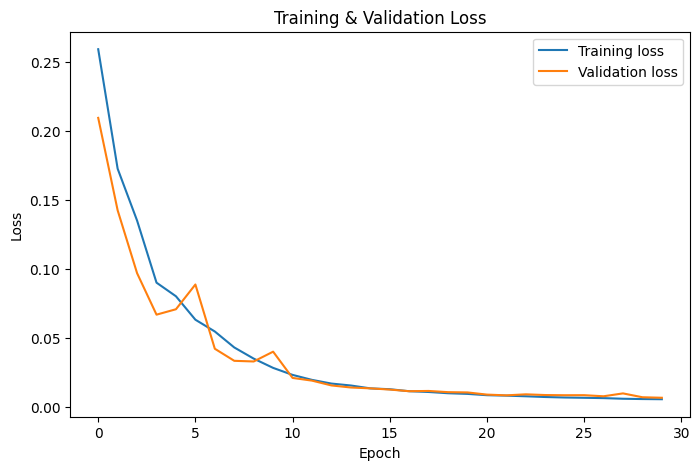

Model saved.


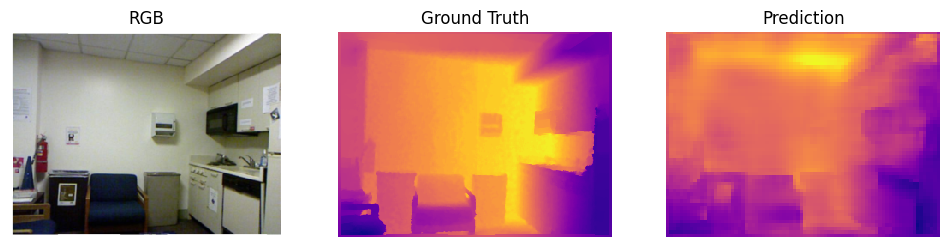

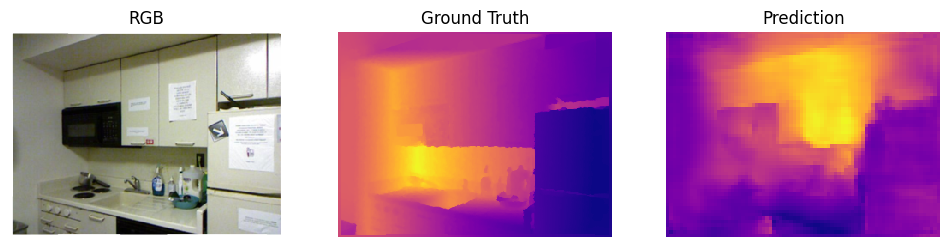

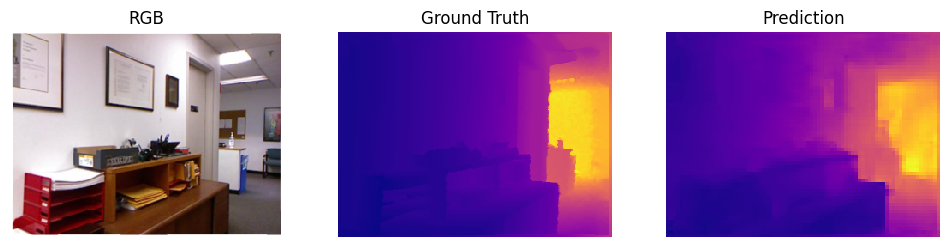

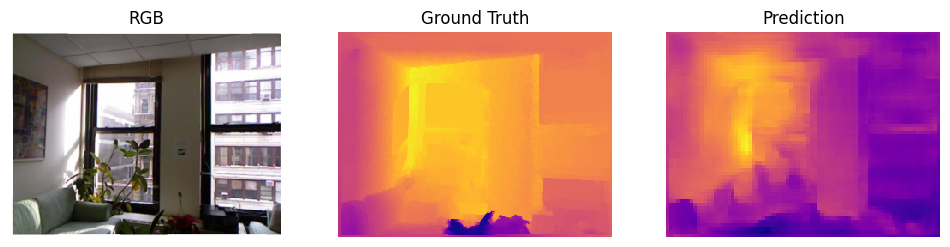

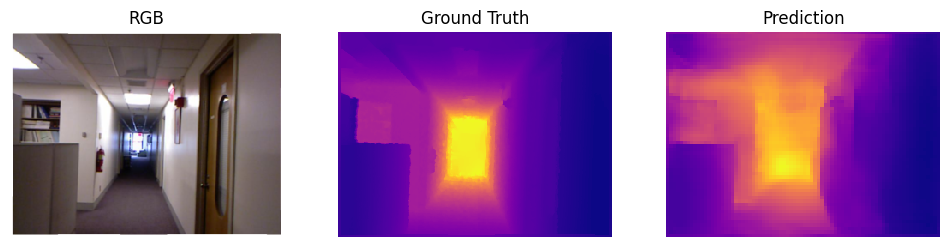

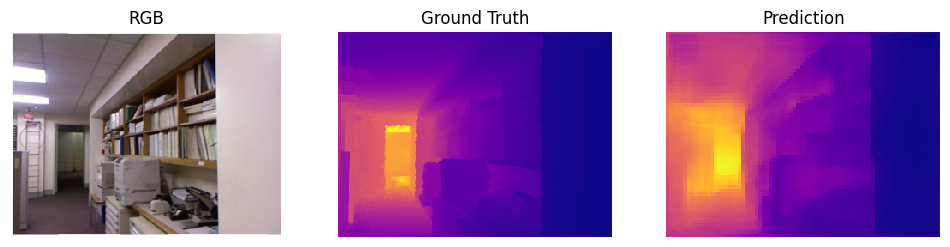

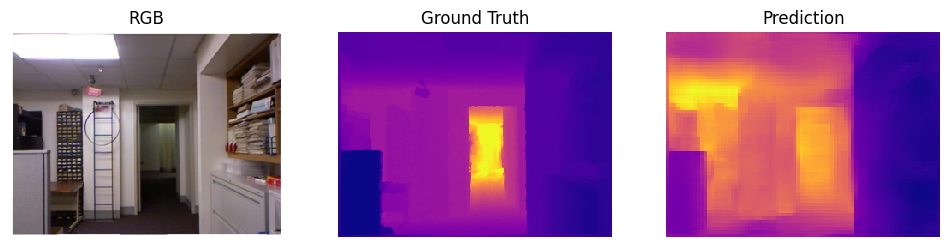

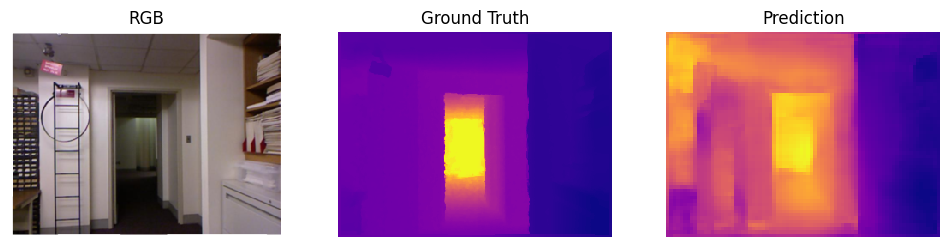

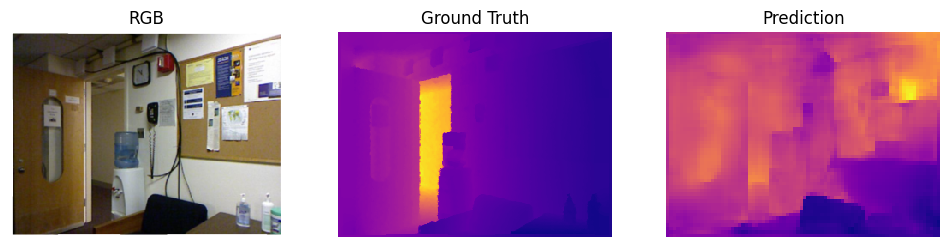

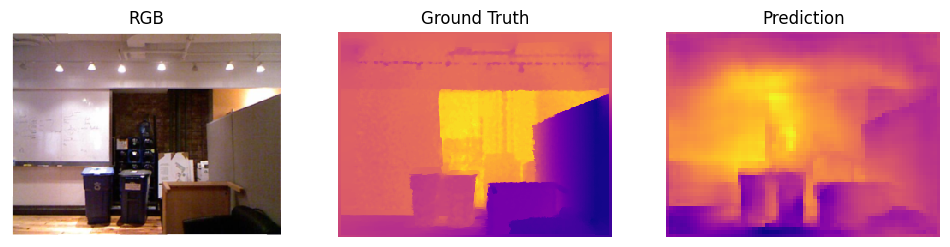

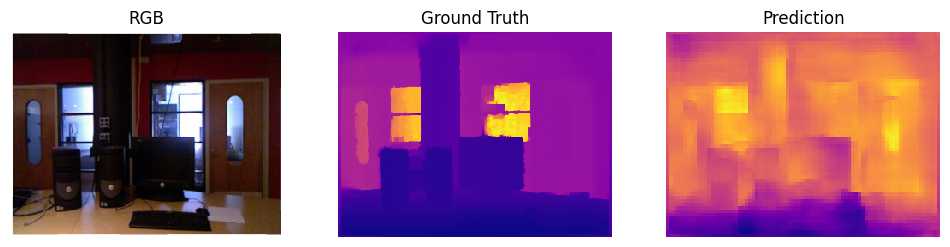

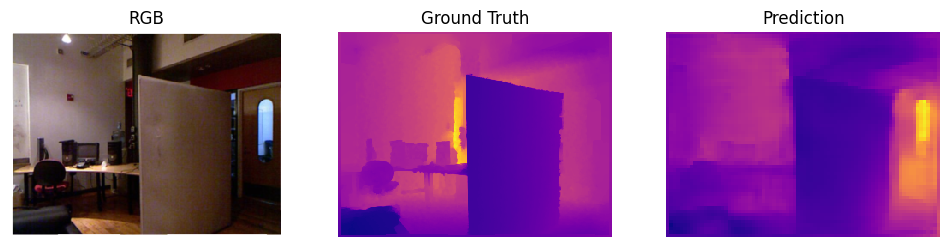

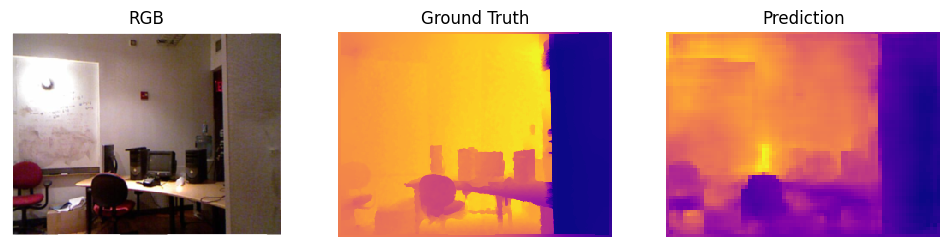

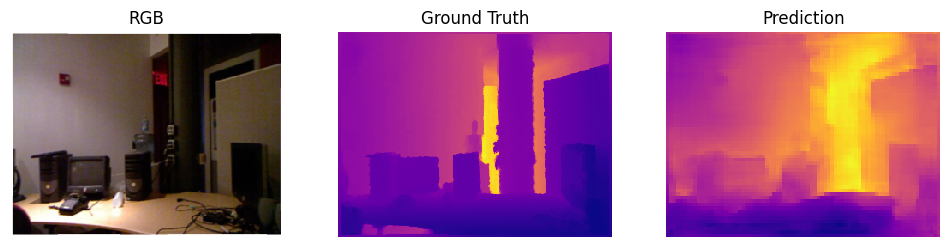

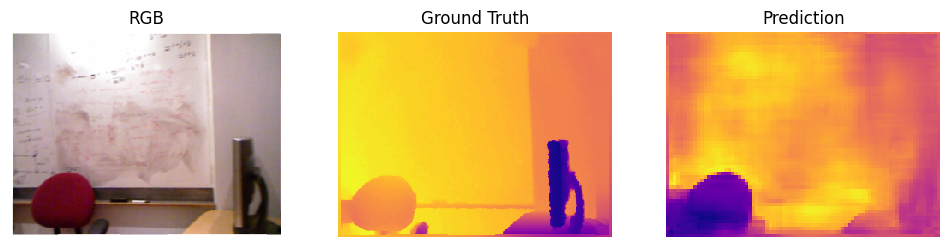

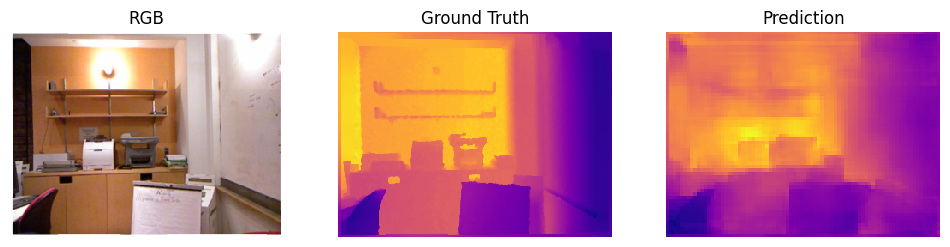

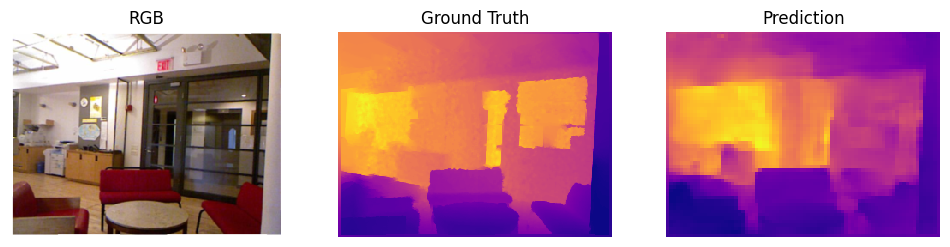

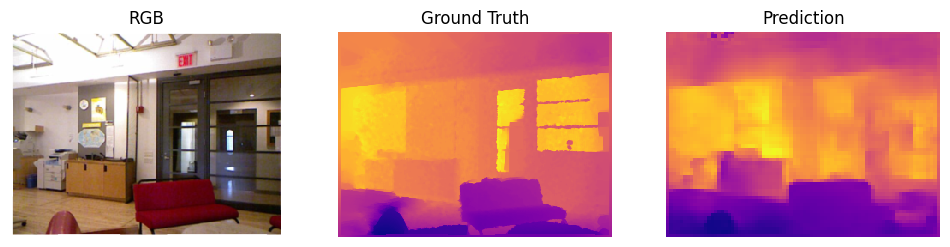

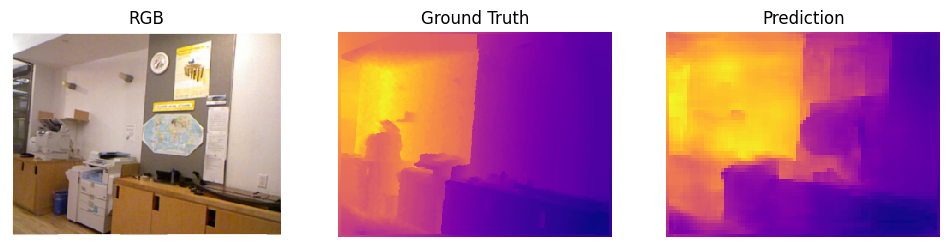

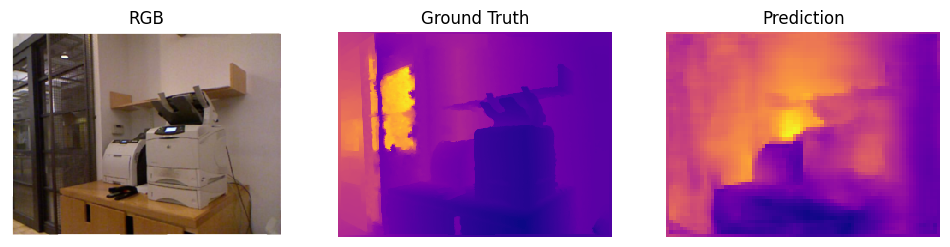

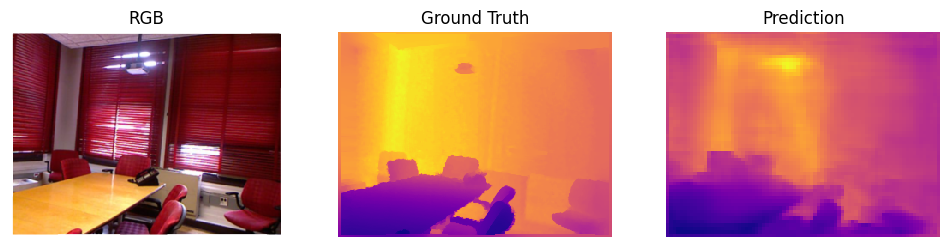

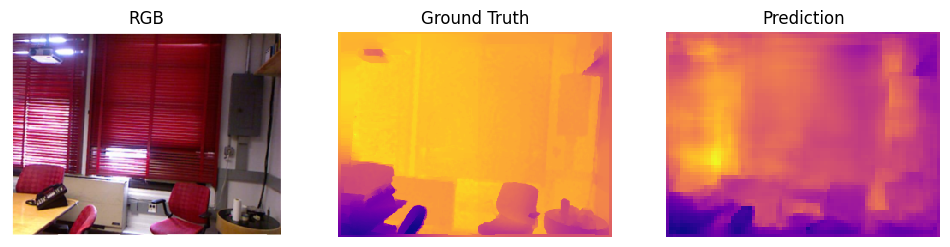

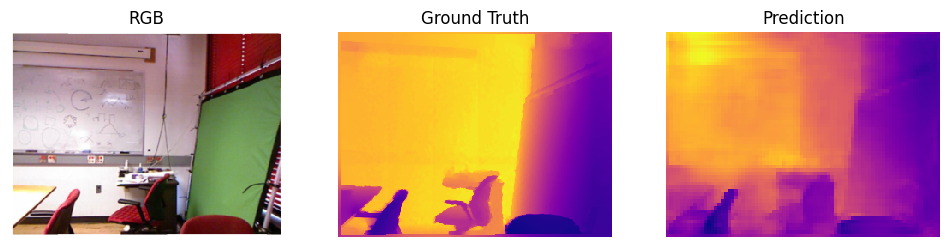

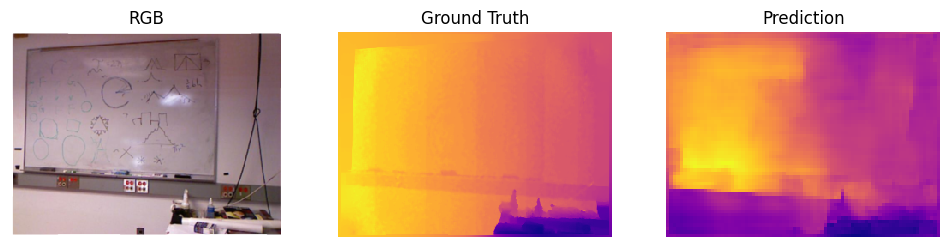

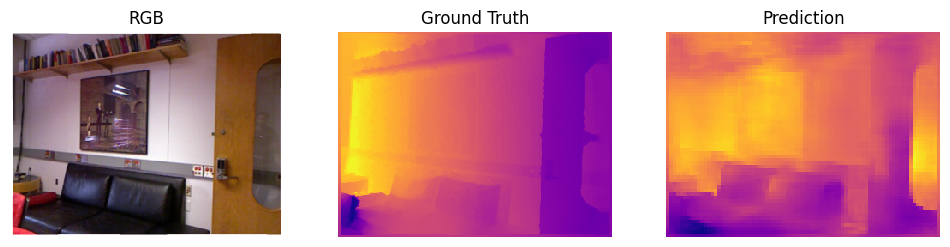

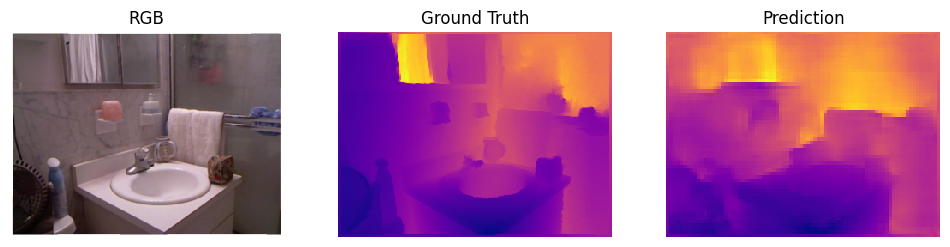

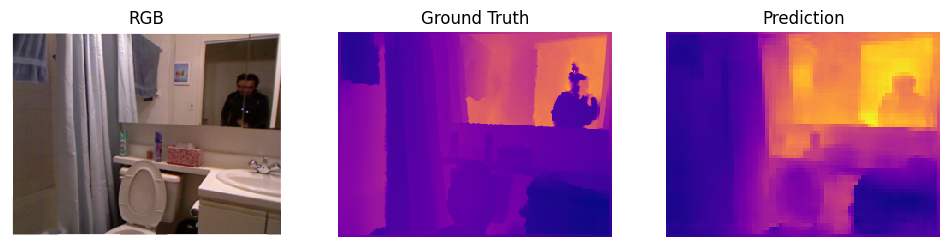

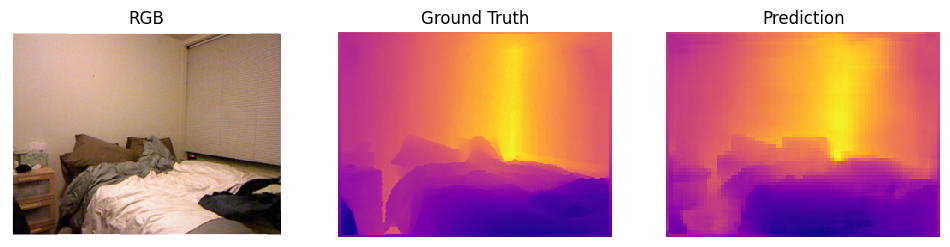

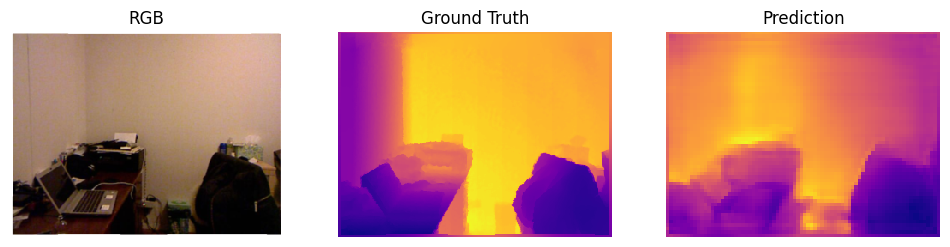

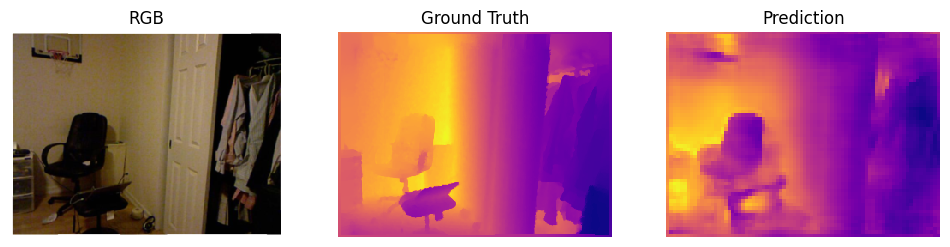

Display complete.


In [14]:
# Plot the validation results: input image-ouput depthmap - groundtruth depthmap
############## Insert your code below ############## 
#Plotting loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses,label='Training loss')
plt.plot(val_losses,  label='Validation loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Training & Validation Loss')
plt.show()

#Saving model
torch.save(model.state_dict(),'dense_unet_nyu.pth')
print("Model saved.")

# Displaying 30 sample predictions
model.eval(); cnt=0
with torch.no_grad():
    for imgs,depths in test_loader:
        imgs,depths = imgs.to(device), depths.to(device)
        preds = model(imgs)
        for i in range(imgs.size(0)):
            rgb = transforms.ToPILImage()(imgs[i].cpu())
            gt  = depths[i].cpu().squeeze(0).numpy()
            pd  = preds[i].cpu().squeeze(0).numpy()
            gt_n = (gt-gt.min())/(gt.max()-gt.min()+1e-8)
            pd_n = (pd-pd.min())/(pd.max()-pd.min()+1e-8)
            fig,axs = plt.subplots(1,3,figsize=(12,4))
            axs[0].imshow(rgb); axs[0].set_title('RGB'); axs[0].axis('off')
            axs[1].imshow(gt_n, cmap='plasma'); axs[1].set_title('Ground Truth'); axs[1].axis('off')
            axs[2].imshow(pd_n, cmap='plasma'); axs[2].set_title('Prediction');axs[2].axis('off')
            plt.show()
            cnt += 1
            if cnt>=30: break
        if cnt>=30: break
print("Display complete.")
####################################################  